In [1]:
pip install yfinance

Note: you may need to restart the kernel to use updated packages.


[*********************100%***********************]  1 of 1 completed

Downloaded Data:
Price           Close       High        Low       Open     Volume
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL
Date                                                             
2020-01-02  72.796021  72.856613  71.545387  71.799873  135480400
2020-01-03  72.088287  72.851753  71.862884  72.020424  146322800
2020-01-06  72.662720  72.701500  70.954010  71.206077  118387200
2020-01-07  72.320984  72.929329  72.100426  72.672417  108872000
2020-01-08  73.484360  73.787323  72.022865  72.022865  132079200


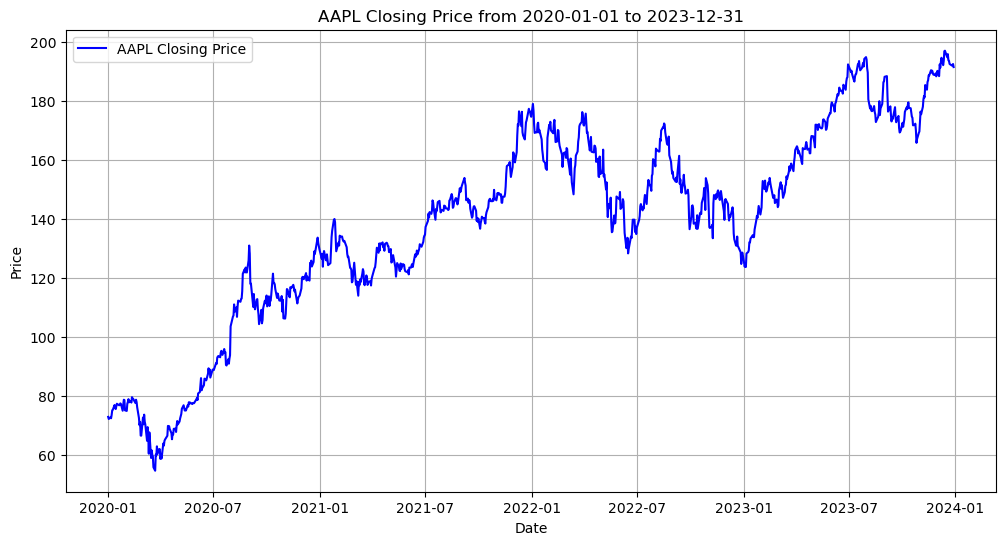

Data saved to AAPL_data.csv


In [2]:
# Import required libraries
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Define the ticker symbol and time period
ticker_symbol = 'AAPL'  # Example: Apple Inc.
start_date = '2020-01-01'
end_date = '2023-12-31'

# Fetch historical data using yfinance
stock_data = yf.download(ticker_symbol, start=start_date, end=end_date)

# Display the first few rows of the data
print("Downloaded Data:")
print(stock_data.head())

# Plot the closing price
plt.figure(figsize=(12, 6))
plt.plot(stock_data['Close'], label=f'{ticker_symbol} Closing Price', color='blue')
plt.title(f'{ticker_symbol} Closing Price from {start_date} to {end_date}')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

# Save the data to a CSV file for further analysis (optional)
csv_filename = f"{ticker_symbol}_data.csv"
stock_data.to_csv(csv_filename)
print(f"Data saved to {csv_filename}")

In [3]:
# Include 'Date' column in the new DataFrame
new_df = pd.DataFrame({
    'Date': stock_data.index,
    'Open': stock_data['Open'].values.ravel(),
    'High': stock_data['High'].values.ravel(),
    'Low': stock_data['Low'].values.ravel(),
    'Close': stock_data['Close'].values.ravel(),
    'Volume': stock_data['Volume'].values.ravel()
})


new_df['Close']

stock_data = new_df

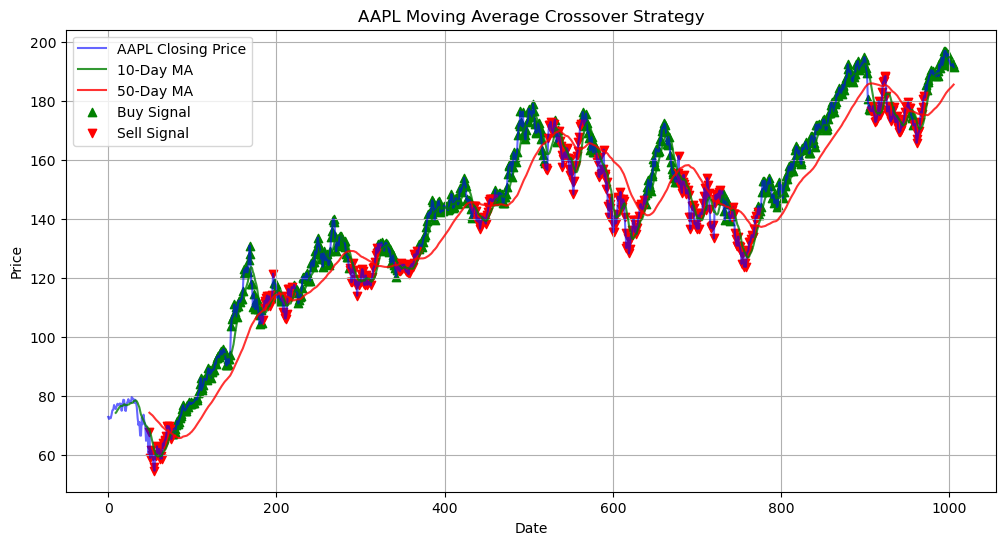

           Close    Short_MA     Long_MA  Signal
1001  192.656174  194.792708  184.403120       1
1002  192.108856  194.779773  184.690418       1
1003  192.208359  194.624532  184.982291       1
1004  192.636292  194.188667  185.313928       1
1005  191.591385  193.633388  185.650706       1


In [4]:

# Calculate moving averages
short_window = 10  # Short-term moving average (e.g., 10 days)
long_window = 50   # Long-term moving average (e.g., 50 days)

stock_data['Short_MA'] = stock_data['Close'].rolling(window=short_window).mean()
stock_data['Long_MA'] = stock_data['Close'].rolling(window=long_window).mean()

# Generate buy and sell signals
stock_data['Signal'] = 0  # Default: No signal
stock_data.loc[stock_data['Short_MA'] > stock_data['Long_MA'], 'Signal'] = 1  # Buy signal
stock_data.loc[stock_data['Short_MA'] <= stock_data['Long_MA'], 'Signal'] = -1  # Sell signal

# Plot the strategy
plt.figure(figsize=(12, 6))
plt.plot(stock_data['Close'], label=f'{ticker_symbol} Closing Price', color='blue', alpha=0.6)
plt.plot(stock_data['Short_MA'], label=f'{short_window}-Day MA', color='green', alpha=0.8)
plt.plot(stock_data['Long_MA'], label=f'{long_window}-Day MA', color='red', alpha=0.8)

# Highlight buy/sell signals
buy_signals = stock_data[stock_data['Signal'] == 1]
sell_signals = stock_data[stock_data['Signal'] == -1]
plt.scatter(buy_signals.index, buy_signals['Close'], marker='^', color='green', label='Buy Signal', alpha=1)
plt.scatter(sell_signals.index, sell_signals['Close'], marker='v', color='red', label='Sell Signal', alpha=1)

# Add chart elements
plt.title(f'{ticker_symbol} Moving Average Crossover Strategy')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

# Print sample data with signals
print(stock_data[['Close', 'Short_MA', 'Long_MA', 'Signal']].tail())

In [5]:
import numpy as np

# Parameters for risk management
initial_capital = 100000  # Initial investment capital in USD
stop_loss_pct = 0.05      # Stop-loss at 5% below entry price
position_size_pct = 0.02  # Risk 2% of capital per trade

# Calculate daily returns
stock_data['Daily_Returns'] = stock_data['Close'].pct_change()

# Backtest the strategy
capital = initial_capital
positions = []  # Track active positions
pnl = []  # Track daily profit and loss

for i in range(1, len(stock_data)):
    # Check signals
    if stock_data['Signal'].iloc[i] == 1:  # Check if positions list is empty
        entry_price = stock_data['Close'].iloc[i]
        risk_per_trade = capital * position_size_pct
        position_size = risk_per_trade / entry_price
        positions.append({'entry_price': entry_price, 'size': position_size})
    
    elif stock_data['Signal'].iloc[i] == -1 and len(positions) > 0:  # Check if positions list is not empty
        for position in positions:
            exit_price = stock_data['Close'].iloc[i]
            profit = (exit_price - position['entry_price']) * position['size']
            pnl.append(profit)
            capital += profit
        positions = []  # Clear positions after sell signal
    
    # Apply stop-loss
if positions:  # Ensure there are active positions
    for position in positions[:]:  # Iterate over a copy of the positions list
        entry_price = float(position['entry_price'])  # 转换为标量浮点数
        stop_loss_price = entry_price * (1 - stop_loss_pct)
        current_price = float(stock_data['Close'].iloc[i])  # 当前价格

        if current_price < stop_loss_price:  # 检查是否触发止损
            exit_price = current_price
            loss = (exit_price - entry_price) * position['size']  # 计算亏损
            pnl.append(loss)  # 保存亏损记录
            capital += loss  # 更新总资金
            positions.remove(position)  # 移除触发止损的头寸


0            NaN
1      -0.009722
2       0.007968
3      -0.004703
4       0.016086
          ...   
1001   -0.005548
1002   -0.002841
1003    0.000518
1004    0.002226
1005   -0.005424
Name: Daily_Returns, Length: 1006, dtype: float64
Total PnL: $37705.85
Yearly PnL: $13680.55
Sharpe Ratio: 0.89


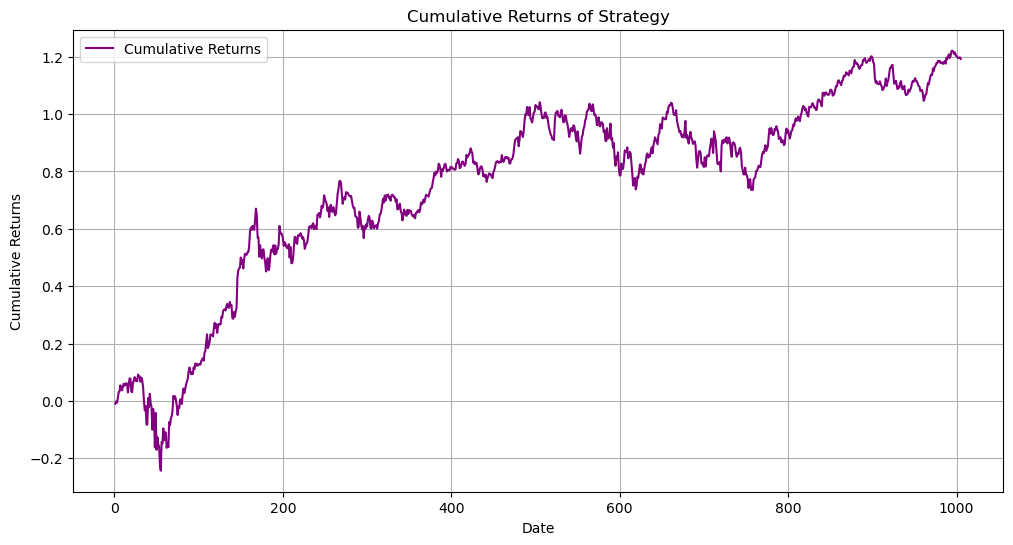

In [8]:

# Calculate strategy metrics
cumulative_returns = np.cumsum(stock_data['Daily_Returns'].dropna())

print(stock_data['Daily_Returns'])

sharpe_ratio = np.mean(stock_data['Daily_Returns']) / np.std(stock_data['Daily_Returns']) * np.sqrt(252)  # Annualized Sharpe Ratio
total_pnl = float(sum(pnl))
yearly_pnl = total_pnl / ((len(stock_data)) / 365)


print(f"Total PnL: ${total_pnl:.2f}")
print(f"Yearly PnL: ${yearly_pnl:.2f}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

# Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(cumulative_returns, label='Cumulative Returns', color='purple')
plt.title('Cumulative Returns of Strategy')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid()
plt.show()